<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports-&amp;-Config" data-toc-modified-id="Imports-&amp;-Config-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Imports &amp; Config</a></span></li><li><span><a href="#Analyze-Dataset-Statistics" data-toc-modified-id="Analyze-Dataset-Statistics-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Analyze Dataset Statistics</a></span><ul class="toc-item"><li><span><a href="#Notable-tokens-and-their-statements" data-toc-modified-id="Notable-tokens-and-their-statements-0.2.1"><span class="toc-item-num">0.2.1&nbsp;&nbsp;</span>Notable tokens and their statements</a></span></li><li><span><a href="#Validation-Set" data-toc-modified-id="Validation-Set-0.2.2"><span class="toc-item-num">0.2.2&nbsp;&nbsp;</span>Validation Set</a></span></li><li><span><a href="#Test-Set" data-toc-modified-id="Test-Set-0.2.3"><span class="toc-item-num">0.2.3&nbsp;&nbsp;</span>Test Set</a></span></li><li><span><a href="#Train-Set" data-toc-modified-id="Train-Set-0.2.4"><span class="toc-item-num">0.2.4&nbsp;&nbsp;</span>Train Set</a></span></li></ul></li></ul></li><li><span><a href="#Devmap" data-toc-modified-id="Devmap-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Devmap</a></span></li><li><span><a href="#Threadcoarsening" data-toc-modified-id="Threadcoarsening-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Threadcoarsening</a></span></li><li><span><a href="#NCC" data-toc-modified-id="NCC-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>NCC</a></span></li><li><span><a href="#Fresh-New-NCC" data-toc-modified-id="Fresh-New-NCC-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fresh New NCC</a></span><ul class="toc-item"><li><span><a href="#TBD" data-toc-modified-id="TBD-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>TBD</a></span></li></ul></li></ul></div>

# Analysis_Dataset_Stats <a class="tocSkip">

## Imports \& Config

In [2]:
# Set editor width to something sane
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import sys
# get root repository path
a = !pwd
repo_root = a[0].rsplit('ProGraML', maxsplit=1,)[0] + 'ProGraML'
print(repo_root)
#insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, repo_root)
repo_root = Path(repo_root)


/home/zacharias/ProGraML


In [4]:
import pickle

import numpy as np
from matplotlib import pyplot as plt
import tqdm
import torch
from torch_geometric.data import Data, DataLoader

In [5]:
from deeplearning.ml4pl.models.ggnn.configs import GGNN_POJ104_Config as GGNNConfig
from deeplearning.ml4pl.models.ggnn.run import Learner
from deeplearning.ml4pl.models.ggnn.modeling import GGNNModel
from deeplearning.ml4pl.poj104.dataset import *


/home/zacharias/ProGraML/deeplearning/ml4pl/models/ggnn/run.py
/home/zacharias/ProGraML


## Analyze Dataset Statistics

### Notable tokens and their statements

```
unreachable,232
ret void,263
!UNK,8564
!IDENTIFIER, 8565
magic/root/ I forgot, 8567
```

In [6]:
def simple_barchart(bins, title, ylog=False):
    plt.figure(figsize=(16, 4))
    plt.title(label=title)
    plt.bar(range(len(bins)), bins) # if not ylog else np.log1p(bins.numpy()))
    if ylog:
        plt.yscale('log')
    else:
        plt.yscale('linear')
    plt.grid(axis='y', which='major' )
    plt.show()

def print_dataset_stats(dataset):
    print(dataset)
    x = []
    y = []
    attr = []
    for i, data in enumerate(dataset):
        x.append(data.x.squeeze(dim=1))
        if hasattr(data, 'y') and data.y is not None:
            y.append(data.y.item())
        attr.append(data.edge_attr)
        
    x = torch.cat(x)
    
    if hasattr(data, 'y') and data.y is not None:
        y = torch.tensor(y)
        ybins = torch.bincount(y, minlength=104)
    
    attr = torch.cat(attr)
    edge_types = attr[:, 0]
    edge_type_bins = torch.bincount(edge_types)

    edge_pos = attr[:, 1]
    edge_pos_bins = torch.bincount(edge_pos)

    #print(x.size())
    bins = torch.bincount(x[:, 0], minlength=8568)

    #print('token, count, percentage of whole')
    s = torch.sum(bins)
    unique = 0
    for i, c in enumerate(bins):
        if c:
            unique += 1
            #print(f"{i}  {c.item()}   {(c*100/s.float()).item():.3f}")
    print(f"No of unique tokens {unique}/8568.")
    print(f"No of tokens in ds: {s:,}.")
    print(f"No of !UNK in data: {bins[8564].item():,} -- [{bins[8564].item()*100/s.item():.2f}%].")
    print(f"No of !ID in data: {bins[8565].item():,} -- [{bins[8565].item()*100/s.item():.2f}%].")

    if hasattr(data, 'y') and data.y is not None:
        simple_barchart(ybins, 'Class Counts')
    
    simple_barchart(edge_type_bins, 'Edge Type Counts')
    simple_barchart(edge_pos_bins, 'Edge Position Counts', ylog=True)    
    

    plt.figure(figsize=(32, 4))
    plt.plot(bins) #, ls='')
    plt.grid(which='both', axis='y')
    plt.yscale('log')
    plt.yticks()
    #plt.plot(bad_log, ls='dotted')
    plt.show()

### Validation Set

In [7]:
ds_dir = repo_root / 'deeplearning/ml4pl/poj104/classifyapp_data'
valid_data = POJ104Dataset(ds_dir, 'val')


In [8]:
len(valid_data)

9152

In [9]:
valid_data.data

Data(edge_attr=[4626934, 2], edge_index=[2, 4626934], x=[2652846, 2], y=[9152])

POJ104Dataset(9152)
No of unique tokens 313/8568.
No of tokens in ds: 2,652,846.
No of !UNK in data: 431,914 -- [16.28%].
No of !ID in data: 1,171,614 -- [44.16%].


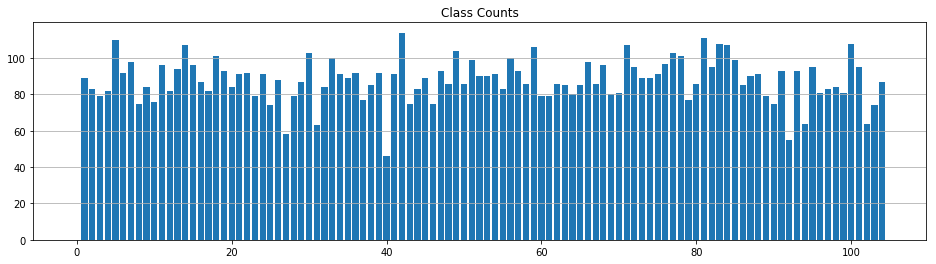

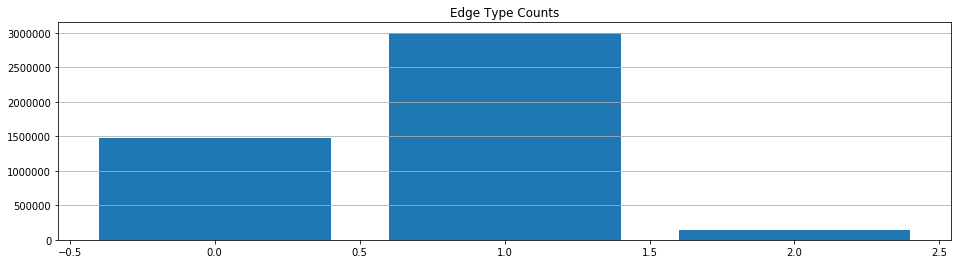

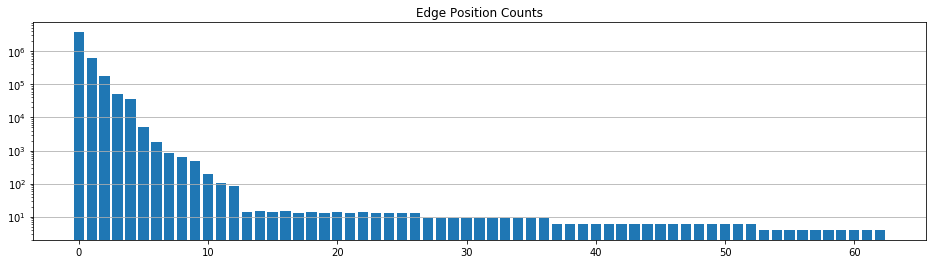

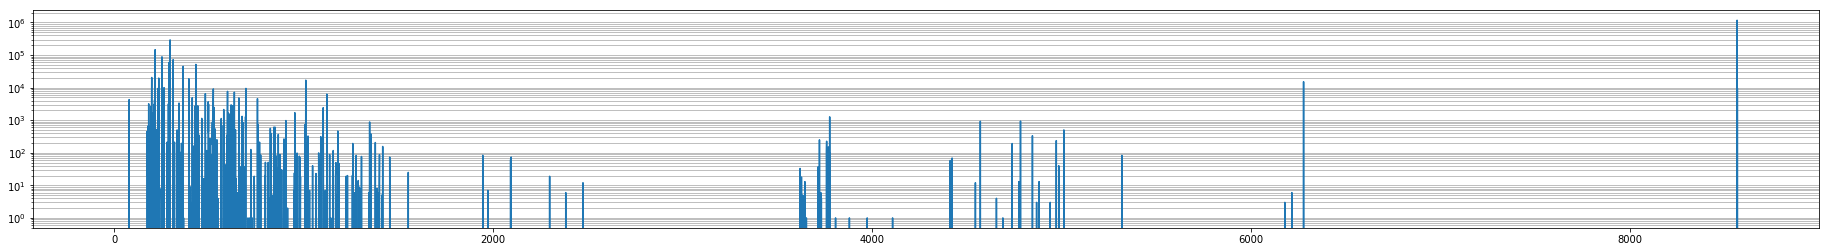

In [10]:
print_dataset_stats(valid_data)

### Test Set

In [11]:
test_data = POJ104Dataset(ds_dir, 'test')

In [12]:
test_data.data

Data(edge_attr=[4566886, 2], edge_index=[2, 4566886], x=[2621085, 2], y=[9223])

POJ104Dataset(9223)
No of unique tokens 318/8568.
No of tokens in ds: 2,621,085.
No of !UNK in data: 426,325 -- [16.27%].
No of !ID in data: 1,157,042 -- [44.14%].


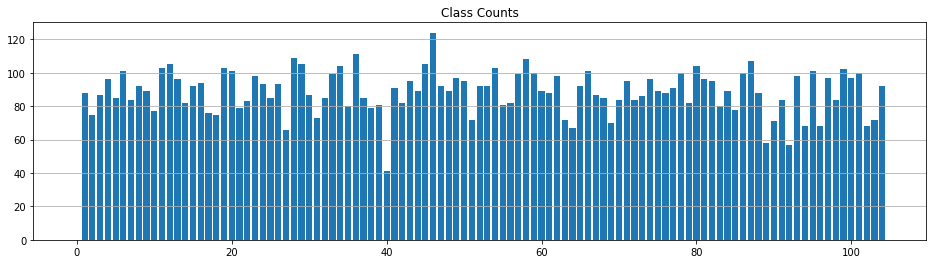

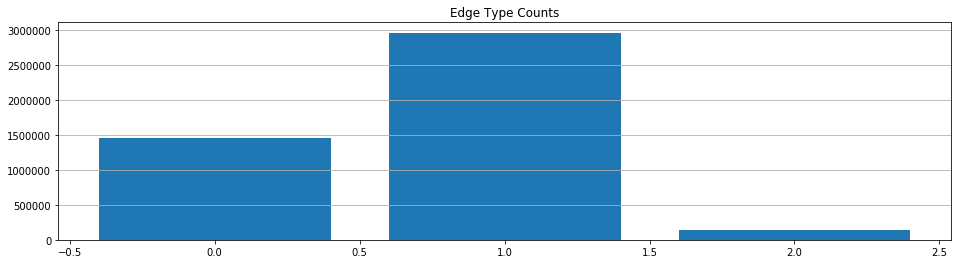

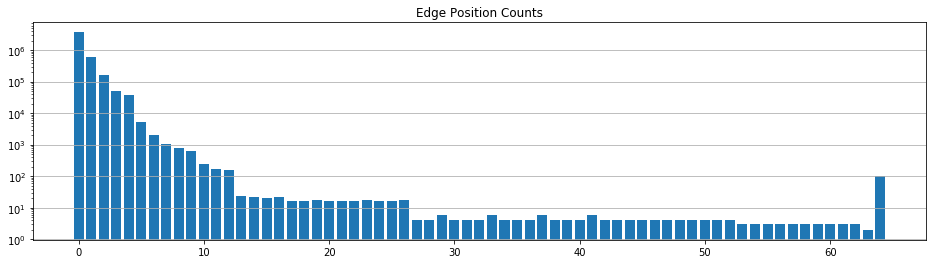

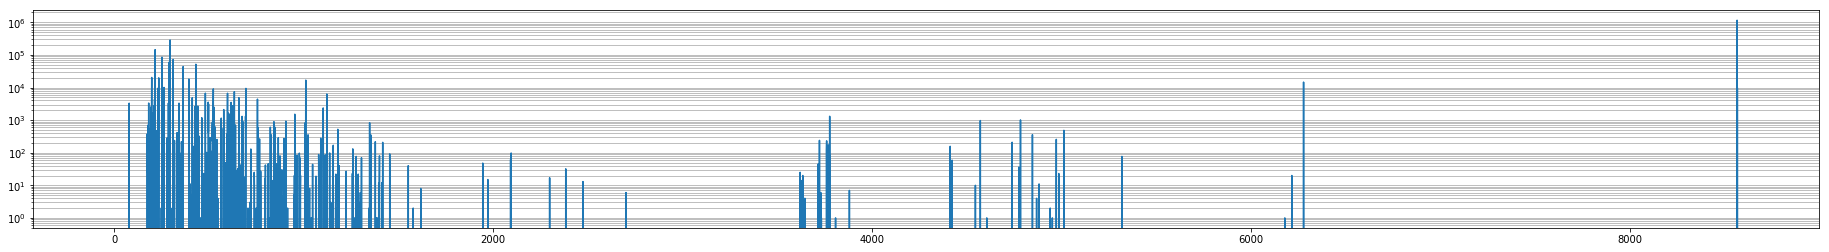

In [13]:
print_dataset_stats(test_data)

### Train Set

In [14]:
train_data = POJ104Dataset(ds_dir, 'train')
print(train_data.data)
print(train_data.data.num_nodes)
print("")

Data(edge_attr=[128940430, 2], edge_index=[2, 128940430], x=[70118083, 2], y=[221079])
70118083



POJ104Dataset(221079)
No of unique tokens 779/8568.
No of tokens in ds: 70,118,083.
No of !UNK in data: 14,518,651 -- [20.71%].
No of !ID in data: 33,273,650 -- [47.45%].


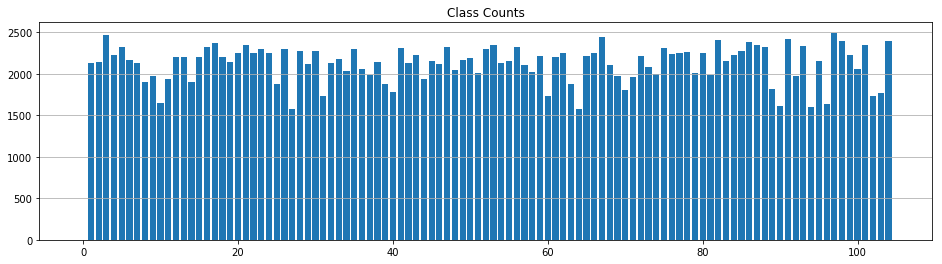

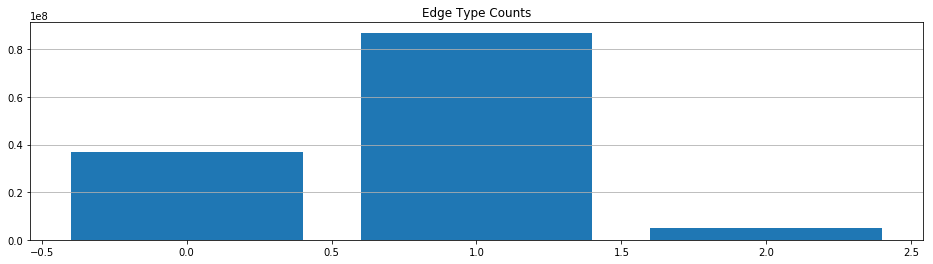

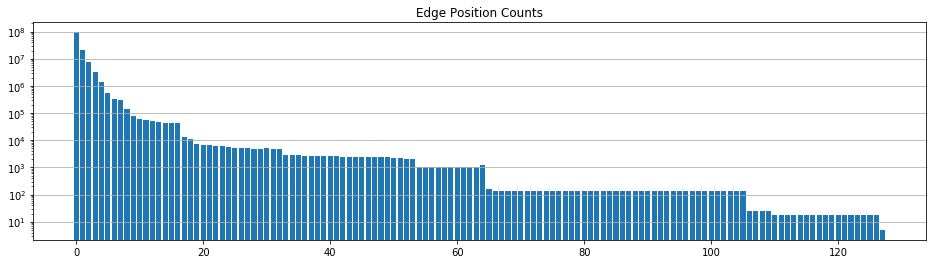

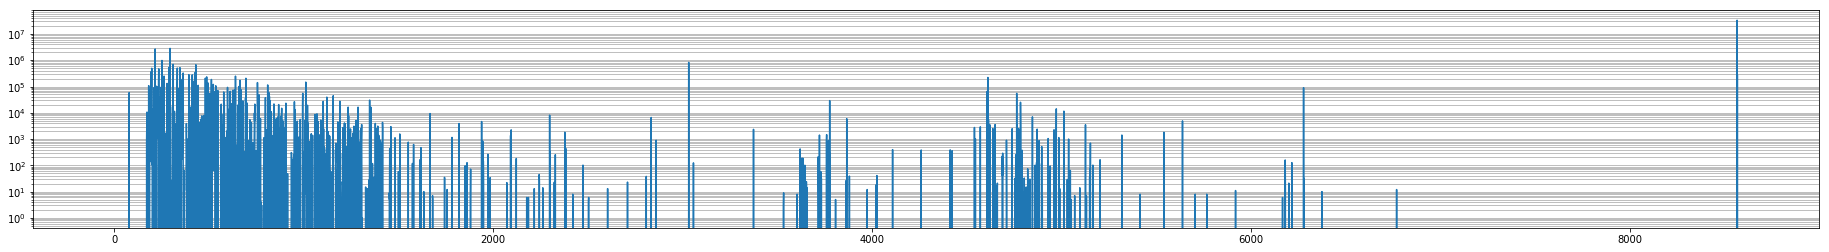

In [17]:
print_dataset_stats(train_data)

# Devmap

Data(aux_in=[680, 2], edge_attr=[781664, 2], edge_index=[2, 781664], runtimes=[680, 2], x=[366743, 2], y=[680])
366743

DevmapDataset(680)
No of unique tokens 328/8568.
No of tokens in ds: 366,743.
No of !UNK in data: 16,966 -- [4.63%].
No of !ID in data: 176,997 -- [48.26%].


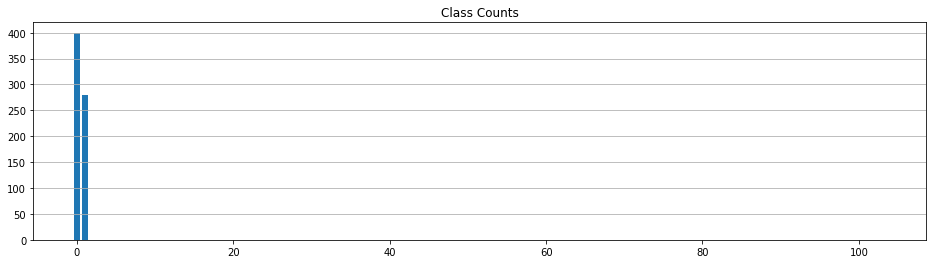

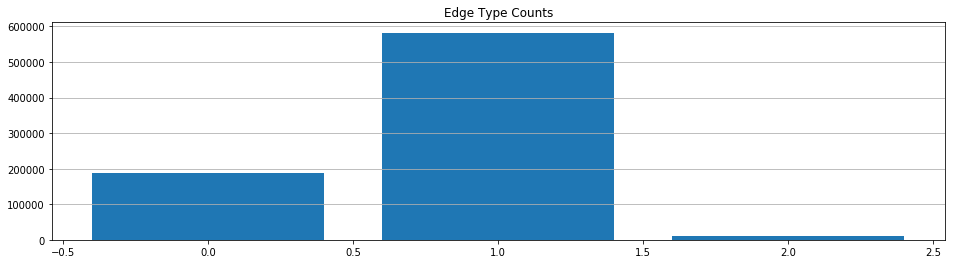

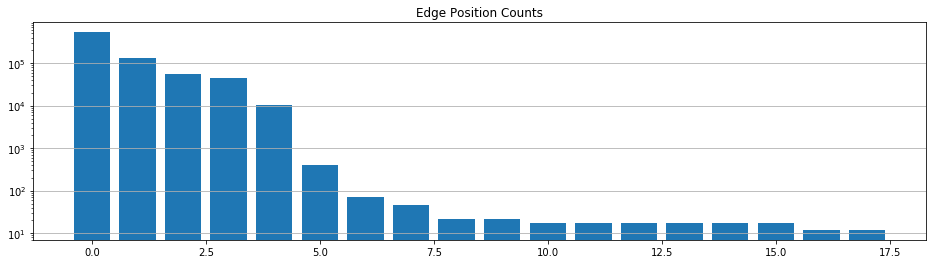

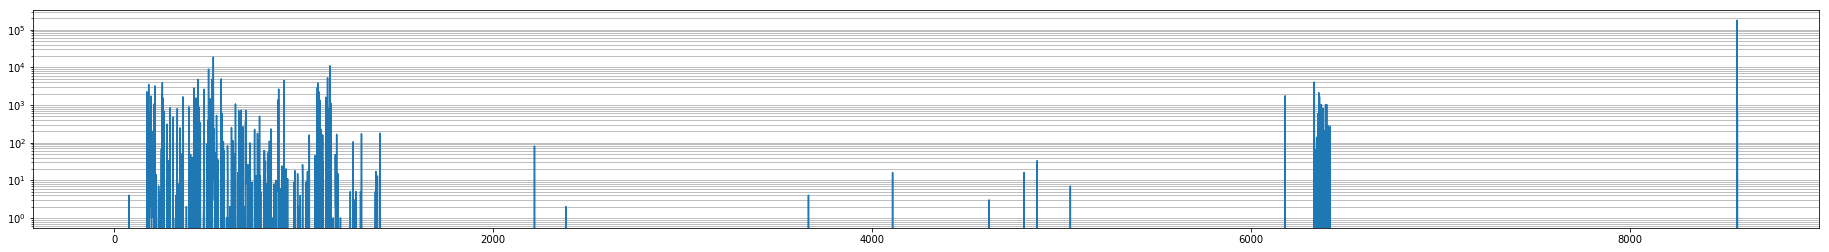

In [18]:
root = '/mnt/data/llvm/master_thesis_datasets/devmap_data/'
a = DevmapDataset(root, 'amd')
print(a.data)
print(a.data.num_nodes)
print("")
print_dataset_stats(a)

# Threadcoarsening

Data(edge_attr=[5456, 2], edge_index=[2, 5456], runtimes=[17, 6], x=[2946, 2], y=[17])
2946

ThreadcoarseningDataset(17)
No of unique tokens 89/8568.
No of tokens in ds: 2,946.
No of !UNK in data: 463 -- [15.72%].
No of !ID in data: 1,489 -- [50.54%].


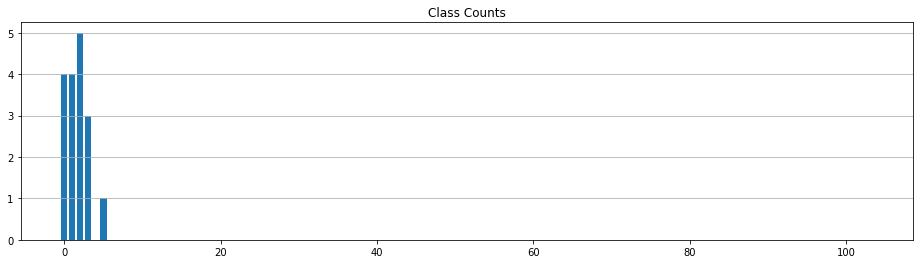

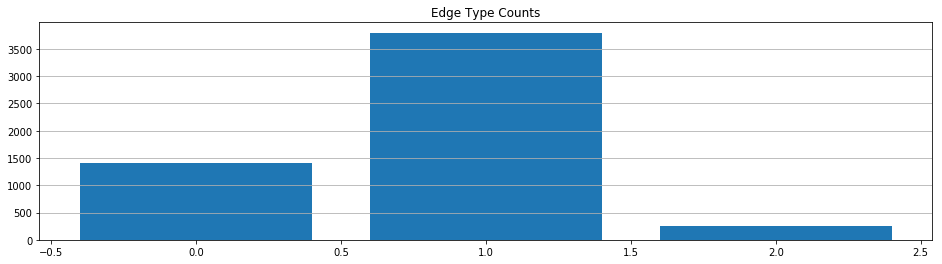

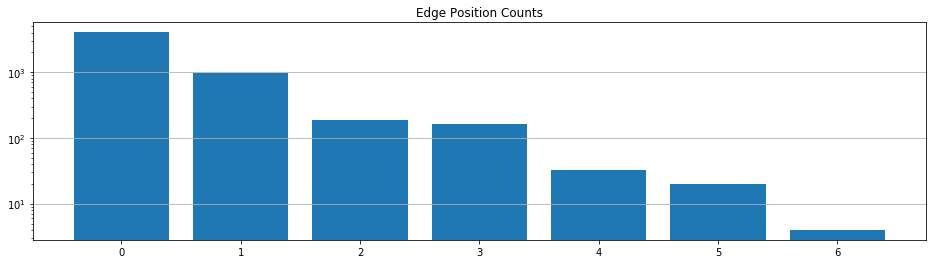

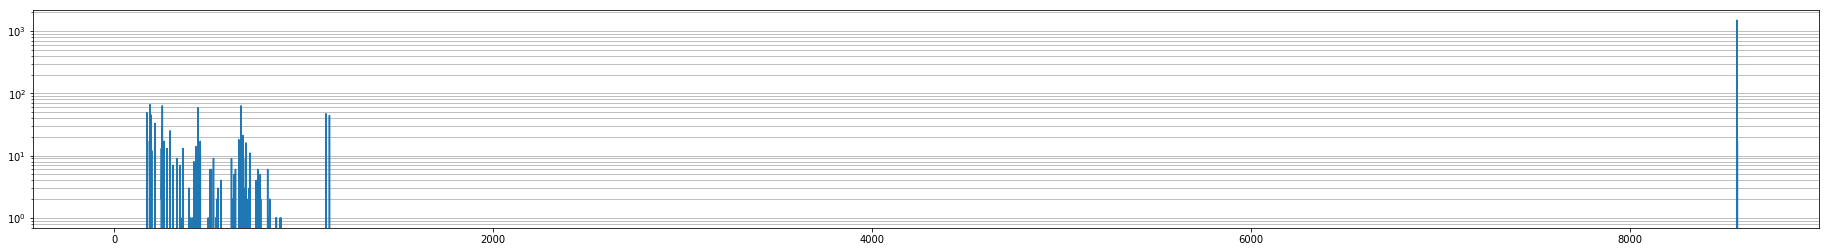

In [19]:
root = '/mnt/data/llvm/master_thesis_datasets/threadcoarsening_data/'
a = ThreadcoarseningDataset(root, 'Cypress')
print(a.data)
print(a.data.num_nodes)
print("")
print_dataset_stats(a)

# NCC 

Data(edge_attr=[59405370, 2], edge_index=[2, 59405370], x=[28400540, 2])
28400540

NCCDataset(20352)
No of unique tokens 1290/8568.
No of tokens in ds: 28,400,540.
No of !UNK in data: 6,202,481 -- [21.84%].
No of !ID in data: 14,131,913 -- [49.76%].


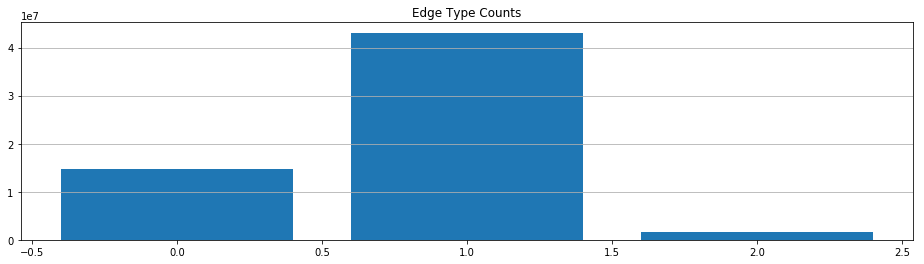

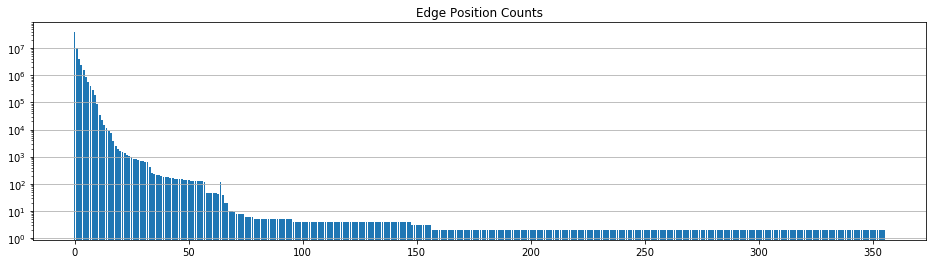

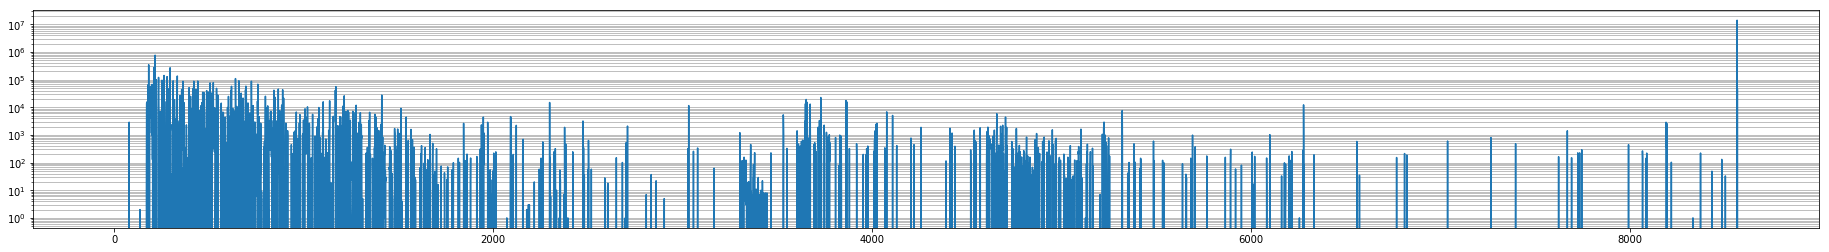

In [20]:
root = '/mnt/data/llvm/master_thesis_datasets/old_unsupervised_ncc_data/'
a = NCCDataset(root, 'train')
print(a.data)
print(a.data.num_nodes)
print("")
print_dataset_stats(a)

# Fresh New NCC

In [21]:

a = dataset.NewNCCDataset()
print(a.data)
print(a.data.num_nodes)
print("")
print_dataset_stats(a)

NameError: name 'dataset' is not defined

## TBD

In [13]:
import networkx.algorithms.isomorphism as iso

from torch_geometric.utils import convert